# The Hopenhayn Entry-Exit Model

------

#### John Stachurski

#### Prepared for the CBC Workshop (May 2024)

## Outline

The Hopenhayn (1992, ECMA) entry-exit model is a highly influential (partial equilibrium) heterogeneous agent model where 

* the agents receiving idiosyncratic shocks are firms, and
* the model produces a non-trivial firm size distribution and a range of predictions for firm dynamics.

We are going to study an extension of the basic model that has unbounded productivity.

Among other things, this allows us to match the heavy tail observed in the firm size distribution data.

The code for computing the equilibrium will be written in Python/JAX.

We will use the following imports.

In [1]:
import numpy as np
import jax.numpy as jnp
import jax.random as random
import jax
import quantecon as qe
import time
import matplotlib.pyplot as plt
from collections import namedtuple

## The Model


### Environment

There is a single good produced by a continuum of competitive firms.

The productivity $\varphi_t = \varphi_t^i$ of each firm evolves randomly on $\mathbb R_+$.

* the $i$ superscript indicates the $i$-th firm and we drop it in what follows

A firm with productivity $\varphi$ facing output price $p$ and wage rate $w$ earns current profits

$$
    \pi(\varphi, p) = p \varphi n^\theta - c  - wn
$$

Here 

- $\theta \in (0,1)$ is a productivity parameter, 
- $c$ is a fixed cost and 
- $n$ is labor input.

Maximizing over $n$ leads to

$$
    \pi(\varphi, p) = (1 - \theta) (p \varphi)^\eta
    \left(\frac{\theta}{w} \right)^{\theta / \eta} - c
$$

where $\eta := 1/(1-\theta)$.

Output is

$$
    q(\varphi, p) = \varphi^\eta
    \left( \frac{p \theta}{w}\right)^{\theta / \eta}
$$  

Productivity of incumbents is independent across firms and grows according to 


$$ \varphi_{t+1} \sim \Gamma(\varphi_t, d \varphi') $$

Here $\Gamma$ is a Markov transition kernel, so that $\Gamma(\varphi, d
                                                             \varphi')$ is the
distribution over $\mathbb R_+$ given $\varphi \in \mathbb R_+$.

For example,

$$ 
   \int \pi(\varphi', p) \Gamma(\varphi, d \varphi')
    = \mathbb E[ \pi(\varphi_{t+1}, p) \,|\, \varphi_t = \varphi ]
$$

New entrants obtain their productivity draw from a fixed distribution $\gamma$.


Demand is 

$$D(p) = 1/p $$

### Firm decisions

The intertemporal firm decision problem is choosing when to exit.

The timing is:

1. produce and receive current profits $\pi(\varphi, p)$
2. decide whether to continue or exit.

Scrap value is set to zero and the discount rate is $\beta \in (0, 1)$.

The firm makes their stop-continue choice by first solving for the value function, which is the unique solution in a class of continuous functions $\mathscr C$ (details omitted) to

\begin{equation}
    v(\varphi, p) = \pi(\varphi, p) + \beta 
        \max \left\{ 0, \int v(\varphi', p) \Gamma(\varphi, d \varphi') \right\}.
\end{equation}

Let $\bar v$ be the unique solution to this functional equation.

Given $\bar v$, we let $\bar \varphi$ be the exit threshold function defined by
%
\begin{equation}
    \bar \varphi(p) := 
    \min
    \left\{ 
        \varphi \geq 0  
        \;\; \big| \;
        \int \bar v(\varphi', p) \, \Gamma(\varphi, d \varphi') \geq 0
    \right\}.
\end{equation}
%
With the convention that incumbents who are indifferent 
remain rather than exit, an incumbent with productivity $\varphi$ exits
if and only if $\varphi < \bar \varphi (p)$.

### Equilibrium 

Now we describe a stationary recursive equilibrium in the model, where

* the goods market clears (supply equals demand)
* the firm size distribution is stationary over time (an invariance condition)
* the mass of entrants equals the mass of exiting firms, and
* entering firms satisfy a break-even condition.

The break-even condition means that expected lifetime value given an initial draw from $\gamma$ is just equal to the fixed cost of entry, which we denote by $c_e$.

Let's now state this more formally

To begin, let $\mathscr B$ be the Borel subsets of $\mathbb R_+$ and $\mathscr M$ be all measures
on $\mathscr B$.  

Taking $\bar v$ and $\bar \varphi$ as defined in the previous
section, a **stationary recursive equilibrium**  is a triple 
%
\begin{equation*}
    (p, M, \mu) \quad \text{ in } \quad
    \mathscr E := (0, \infty) \times (0, \infty) \times \mathscr M,
\end{equation*}
%
with $p$ understood as price, $M$ as mass of entrants, and $\mu$ as a
distribution of firms over productivity levels, such that the goods market clears, or
%
\begin{equation}
    \int q( \varphi, p) \mu(d \varphi) = D(p),
\end{equation}
%
the *invariance condition* over the firm distribution
%
\begin{equation}
    \mu (B) 
    = \int \Gamma(\varphi, B) \, \mathbf{1}  \{\varphi \geq \bar \varphi(p)\} \,
    \mu(d \varphi)
    + M \, \gamma(B) 
    \text{ for all } B \in \mathscr B,
\end{equation}
%
holds (see below for intuition), the *equilibrium entry condition*
%
\begin{equation}
    \int \bar v( \varphi, p) \, \gamma(d \varphi) = c_e
\end{equation}
%
holds, and the *balanced entry and exit condition*
%
\begin{equation}
    M = \mu \{ \varphi < \bar \varphi(p) \}
\end{equation}
%
is verified.

The invariance condition says that, for any subset $B$ of the state space, the mass of firms with productivity in set $B$ today (the left-hand side) is equal to the mass of firms with productivity in set $B$ tomorrow (the right-hand side).

### Computing equilibrium

We compute the equilibrium as follows:

For the purposes of this section, we insert balanced entry and
exit into the time invariance condition, yielding
%
\begin{equation}
    \mu (B) 
    = \int \Pi(\varphi, B) \mu (d \varphi)
    \quad \text{for all } B \in \mathscr B,
\end{equation}
%
where $\Pi$ is the transition kernel on $\mathbb R_+$ defined by
%
\begin{equation}
    \Pi(\varphi, B) 
    = \Gamma(\varphi, B) \mathbf{1} \{\varphi \geq \bar \varphi(p) \} + 
    \mathbf{1} \{\varphi < \bar \varphi(p)\} \gamma(B).
\end{equation}
%

Under our assumptions, for each $p > 0$, there exists a unique $\mu$ satisfying
this invariance law.

Let $\mathscr P$ be the probability measures on $\mathbb R_+$.

The unique stationary equilibrium can be computed as follows:

1. Obtain $\bar v$ as the unique solution to the Bellman equation, and
        then calculate the exit threshold function $\bar \varphi$.
2. Solve for the equilibrium entry price $p^*$ by solving the entry condition.
3. Define $\Pi$ as above, using $p^*$ as the price, and compute $\mu$
        as the unique solution to the invariance condition.
4. Rescale $\mu$ by setting $s := D(p^*)/ \int q( \varphi, p^*)
        \mu(d \varphi)$ and then $\mu^* := s \, \mu$.
5. Obtain the mass of entrants via $M^* = \mu^* \{ \varphi < \bar \varphi(p^*) \}$.

When we compute the distribution $\mu$ in step 3, we will use the fact that it
is the stationary distribution of the Markov transition kernel $\Pi(\varphi, d
                                                                    \varphi)$.

This transition kernel turns out to be *ergodic*, which means that if we simulate a cross-section of firms according to $\Pi$ for a large number of periods, the resulting sample (cross-section of productivities) will approach a set of IID draws from $\mu$.  

This allows us to 

1. compute integrals with respect to the distribution using Monte Carlo, and
2. investigate the shape and properties of the stationary distribution.

### Specification of dynamics

Before solving the model we need to specify $\Gamma$ and $\gamma$.

We assume $\Gamma(\varphi, d \varphi')$ is given by

$$
    \varphi_{t+1} = A_{t+1} \varphi_t 
$$

We assume that $(A_t)$ is IID over time, independent across firms, and lognormal $LN(m_a, \sigma_a)$.

(This means that incumbents follow Gibrat's law, which is a reasonable assumption for medium to large firms -- and hence for incumbents.)

New entrants are drawn from a lognormal distribution $LN(m_e, \sigma_e)$.

## Code

We use 64 bit floats for extra precision.

In [2]:
jax.config.update("jax_enable_x64", True)

We store the parameters, grids and Monte Carlo draws in a `namedtuple`.

In [3]:
Parameters = namedtuple("Parameters", 
    ("β",             # discount factor        
     "θ",             # labor productivity
     "c",             # fixed cost in production
     "c_e",           # entry cost
     "w",             # wages
     "m_a",           # productivity shock location parameter
     "σ_a",           # productivity shock scale parameter
     "m_e",           # new entrant location parameter
     "σ_e"))          # new entrant scale parameter

In [4]:
Grids = namedtuple("Grids",
    ("φ_grid",        # productivity grid
     "E_draws",       # entry size draws for Monte Carlo
     "A_draws"))      # productivity shock draws for Monte Carlo

In [5]:
Model = namedtuple("Model",
    ("parameters",    # instance of Parameters
     "grids"))        # instance of Grids

In [6]:
def create_model(β=0.95,             # discount factor
                 θ=0.3,              # labor productivity
                 c=4.0,              # fixed cost in production
                 c_e=1.0,            # entry cost
                 w=1.0,              # wages
                 m_a=-0.012,         # productivity shock location parameter
                 σ_a=0.1,            # productivity shock scale parameter
                 m_e=1.0,            # new entrant location parameter
                 σ_e=0.2,            # new entrant scale parameter
                 φ_grid_max=5,       # productivity grid max
                 φ_grid_size=100,    # productivity grid size
                 E_draw_size=200,    # entry MC integration size
                 A_draw_size=200,    # prod shock MC integration size
                 seed=1234):         # Seed for MC draws
    """
    Create an instance of the `namedtuple` Model using default parameter values.
    """
    
    # Test stability
    assert m_a + σ_a**2 / (2 * (1 - θ)) < 0, "Stability condition fails"
    # Build grids and initialize random number generator
    φ_grid = jnp.linspace(0, φ_grid_max, φ_grid_size)
    key, subkey = random.split(random.PRNGKey(seed))
    # Generate a sample of draws of A for Monte Carlo integration
    A_draws = jnp.exp(m_a + σ_a * jax.random.normal(key, (A_draw_size,)))
    # Generate a sample of draws from γ for Monte Carlo
    E_draws = jnp.exp(m_e + σ_e * jax.random.normal(subkey, (E_draw_size,)))
    # Build namedtuple and return
    parameters = Parameters(β, θ, c, c_e, w, m_a, σ_a, m_e, σ_e)
    grids = Grids(φ_grid, E_draws, A_draws)
    model = Model(parameters, grids)
    return model

Let us write down functions for profits and output.

In [7]:
@jax.jit
def π(φ, p, parameters):
    " Profits. "
    # Unpack
    β, θ, c, c_e, w, m_a, σ_a, m_e, σ_e = parameters
    # Compute profits
    return (1 - θ) * (p * φ)**(1/(1 - θ)) * (θ/w)**(θ/(1 - θ)) - c 

In [8]:
@jax.jit
def q(φ, p, parameters):
    " Output. "
    # Unpack
    β, θ, c, c_e, w, m_a, σ_a, m_e, σ_e = parameters
    # Compute output
    return φ**(1/(1 - θ)) * (p * θ/w)**(θ/(1 - θ)) 

Let's write code to simulate a cross-section of firms given a particular value for the exit threshold (rather than an exit threshold function).

Firms that exit are immediately replaced by a new entrant, drawn from $\gamma$.

Our first function updates by one step

In [9]:
def update_cross_section(φ_bar, φ_vec, key, parameters, num_firms):
    # Unpack
    β, θ, c, c_e, w, m_a, σ_a, m_e, σ_e = parameters
    # Update
    Z = random.normal(key, (2, num_firms))  # long rows for row-major arrays
    incumbent_draws = φ_vec * jnp.exp(m_a + σ_a * Z[0, :])
    new_firm_draws = jnp.exp(m_e + σ_e * Z[1, :])
    return jnp.where(φ_vec >= φ_bar, incumbent_draws, new_firm_draws)

In [10]:
update_cross_section = jax.jit(update_cross_section, static_argnums=(4,))

Our next function runs the cross-section forward in time `sim_length` periods.

In [11]:
def simulate_firms(φ_bar, parameters, grids, 
                   sim_length=200, num_firms=1_000_000, seed=12):
    """
    Simulate a cross-section of firms when the exit threshold is φ_bar.

    """
    # Set initial conditions to the threshold value
    φ_vec = jnp.ones((num_firms,)) * φ_bar 
    key = random.PRNGKey(seed)
    # Iterate forward in time
    for t in range(sim_length):
        key, subkey = random.split(key)
        φ_vec = update_cross_section(φ_bar, φ_vec, subkey, parameters, num_firms)
    return φ_vec

Here's a utility function to compute the expected value

$$
    \int v(\varphi') \Gamma(\varphi, d \varphi') = \mathbb E v(A_{t+1} \varphi)
$$

given $\varphi$

In [12]:
@jax.jit
def _compute_exp_value_at_phi(v, φ, grids):
    """
    Compute 
    
        E[v(φ')| φ] = Ev(A φ) 
        
    using linear interpolation and Monte Carlo. 
    """
    # Unpack
    φ_grid, E_draws, A_draws = grids
    # Set up V
    Aφ = A_draws * φ 
    vAφ  = jnp.interp(Aφ, φ_grid, v)  # v(A_j φ) for all j
    # Return mean 
    return jnp.mean(vAφ)     # (1/n) Σ_j v(A_j φ)

Now let's vectorize this function in $\varphi$ and then write another function that computes the expected value across all $\varphi$ in `φ_grid`

In [13]:
compute_exp_value_at_phi = jax.vmap(_compute_exp_value_at_phi, (None, 0, None))

In [14]:
@jax.jit
def compute_exp_value(v, grids):
    """
    Compute 
    
        E[v(φ_prime)| φ] = Ev(A φ) for all φ, as a vector

    """
    # Unpack
    φ_grid, E_draws, A_draws = grids
    return compute_exp_value_at_phi(v, φ_grid, grids)

Here is the Bellman operator $T$.

In [15]:
@jax.jit
def T(v, p, parameters, grids):
    " Bellman operator. "
    # Unpack
    β, θ, c, c_e, w, m_a, σ_a, m_e, σ_e = parameters
    φ_grid, E_draws, A_draws = grids
    # Compute Tv
    EvAφ = compute_exp_value(v, grids)
    return π(φ_grid, p, parameters) + β * jnp.maximum(0.0, EvAφ)

The next function takes $v, p$ as inputs and, conditional on the value function
$v$, computes the value $\bar \varphi(p)$ that corresponds to the exit value.

In [16]:
@jax.jit
def get_threshold(v, grids):
    " Compute the exit threshold. "
    # Unpack
    φ_grid, E_draws, A_draws = grids
    # Compute exit threshold: φ such that E v(A φ) = 0
    EvAφ = compute_exp_value(v, grids)
    i = jnp.searchsorted(EvAφ, 0.0)
    return φ_grid[i]

We use value function iteration (VFI) to compute the value function $\bar v(\cdot, p)$, taking $p$ as given.

VFI is relatively cheap and simple in this setting.

In [17]:
@jax.jit
def vfi(p, v_init, parameters, grids, tol=1e-6, max_iter=10_000):
    """
    Implement value function iteration to solve for the value function.
    """
    # Unpack
    φ_grid, E_draws, A_draws = grids
    # Set up
    def cond_function(state):
        i, v, error = state
        return jnp.logical_and(i < max_iter, error > tol)
    def body_function(state):
        i, v, error = state
        new_v = T(v, p, parameters, grids)
        error = jnp.max(jnp.abs(v - new_v))
        i += 1
        return i, new_v, error
    # Loop till convergence
    init_state = 0, v_init, tol + 1
    state = jax.lax.while_loop(cond_function, body_function, init_state) 
    i, v, error = state
    return v

In [18]:
@jax.jit
def compute_net_entry_value(p, v_init, parameters, grids):
    """
    Returns the net value of entry, which is 
        
         \int v_bar(φ, p) γ(d φ) - c_e

    This is the break-even condition for new entrants.  The argument
    v_init is used as an initial condition when computing v_bar for VFI.
    """
    c_e = parameters.c_e
    φ_grid = grids.φ_grid
    E_draws = grids.E_draws
    v_bar = vfi(p, v_init, parameters, grids)
    v_φ = jnp.interp(E_draws, φ_grid, v_bar)
    Ev_φ = jnp.mean(v_φ)
    return Ev_φ - c_e, v_bar

We need to solve for the equilibrium price, which is the $p$ satisfying

$$
\int \bar v(\varphi', p) \gamma(d \varphi') = c_e
$$

At each price $p$, we need to recompute $\bar v(\cdot, p)$ and then take the expectation.

The technique we will use is bisection.

We will write our own bisection routine because, when we shift to a new price, we want to update the initial condition for value function iteration to the value function from the previous price.

In [19]:
def compute_p_star(parameters, grids, p_min=1.0, p_max=2.0, tol=10e-5):
    """
    Compute the equilibrium entry price p^* via bisection.

    Return both p* and the corresponding value function v_bar, which is
    computed as a byproduct.
    
    Implements the bisection root finding algorithm to find p_star

    """
    φ_grid, E_draws, A_draws = grids
    lower, upper = p_min, p_max
    v_bar = jnp.zeros_like(φ_grid)  # Initial condition at first price guess

    while upper - lower > tol:
        mid = 0.5 * (upper + lower)
        entry_val, v_bar = compute_net_entry_value(mid, v_bar, parameters, grids)
        if entry_val > 0:   # Root is between lower and mid
            lower, upper = lower, mid
        else:               # Root is between mid and upper
            lower, upper = mid, upper

    p_star = 0.5 * (upper + lower)
    return p_star, v_bar

We are now ready to compute all elements of the stationary recursive equilibrium.

In [20]:
def compute_equilibrium_prices_and_quantities(model):
    """
    Compute 

        1. The equilibrium outcomes for p*, v* and φ*, where φ* is the
           equilibrium exit threshold φ_bar(p*).
        1. The scaling factor necessary to convert the stationary probability
           distribution μ into the equilibrium firm distribution μ* = s μ.
        2. The equilibrium mass of entrants M* = μ*{ φ < φ*}

    """
    # Unpack
    parameters, grids = model
    # Compute prices and values
    p_star, v_bar = compute_p_star(parameters, grids)
    # Get φ_star = φ_bar(p_star), the equilibrium exit threshold 
    φ_star = get_threshold(v_bar, grids)
    # Generate an array of draws from μ, the normalized stationary distribution.
    φ_sample = simulate_firms(φ_star, parameters, grids)
    # Compute s to scale μ
    demand = 1 / p_star
    pre_normalized_supply = jnp.mean(q(φ_sample, p_star, parameters))
    s = demand / pre_normalized_supply
    # Compute M* = μ*{ φ < φ_star}
    m_star = s * jnp.mean(φ_sample < φ_star)
    # return computed objects
    return p_star, v_bar, φ_star, φ_sample, s, m_star

## Solving the model

### Preliminary calculations

Let's create an instance of the model.

In [21]:
model = create_model()
parameters, grids = model

Let's see how long it takes to compute the value function at a given price
from a cold start.

In [22]:
p = 2.0
v_init = jnp.zeros_like(grids.φ_grid)            # Initial condition 
%time v_bar = vfi(p, v_init, parameters, grids) 

CPU times: user 222 ms, sys: 4.99 ms, total: 227 ms
Wall time: 244 ms


In [23]:
%time v_bar = vfi(p, v_init, parameters, grids)  

CPU times: user 15.8 ms, sys: 4.29 ms, total: 20.1 ms
Wall time: 18.9 ms


Let's have a look at the net entry value as a function of price

The root is the equilibrium price at the given parameters

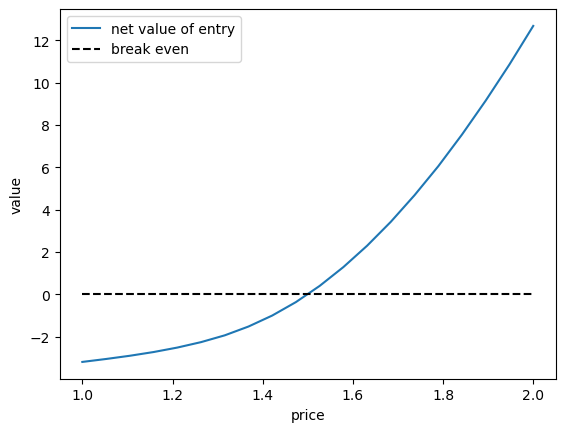

In [24]:
p_min, p_max, p_size = 1.0, 2.0, 20
p_vec = jnp.linspace(p_min, p_max, p_size)
entry_vals = np.empty_like(p_vec)
v_bar = jnp.zeros_like(grids.φ_grid)  # Initial condition at first price guess
for i, p in enumerate(p_vec):
    entry_val, v_bar = compute_net_entry_value(p, v_bar, parameters, grids)
    entry_vals[i] = entry_val
fig, ax = plt.subplots()
ax.plot(p_vec, entry_vals, label="net value of entry")
ax.plot(p_vec, np.zeros_like(p_vec), 'k', ls='--', label="break even")
ax.legend()
ax.set_xlabel("price")
ax.set_ylabel("value")
plt.show()

Below we solve for the zero of this function to calculate $p*$.

From the figure it looks like $p^*$ will be close to 1.5.

### Computing the equilibrium

Now let's try computing the equilibrium

In [25]:
%%time
p_star, v_bar, φ_star, φ_sample, s, m_star = \
        compute_equilibrium_prices_and_quantities(model)

CPU times: user 1.53 s, sys: 97 ms, total: 1.63 s
Wall time: 1.38 s


Let's check that $p^*$ is close to 1.5

In [26]:
p_star

1.500213623046875

Here is a plot of the value function $\bar v(\cdot, p^*)$.

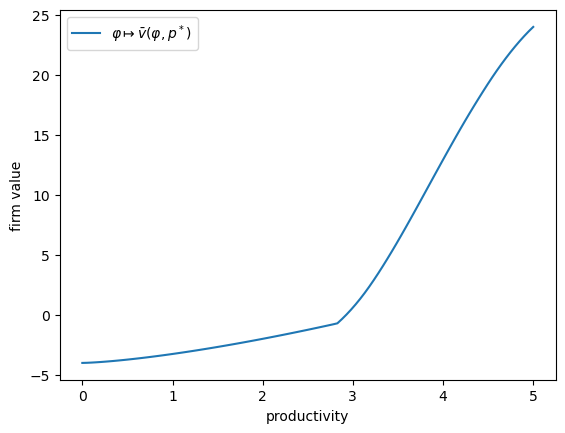

In [27]:
fig, ax = plt.subplots()
ax.plot(grids.φ_grid, v_bar, label=r'$\varphi \mapsto \bar v(\varphi, p^*)$')
ax.set_xlabel("productivity")
ax.set_ylabel("firm value")
ax.legend()
plt.show()

Let's have a look at the firm size distribution, with firm size measured by output.

In [28]:
output_dist = q(φ_sample, p_star, parameters)

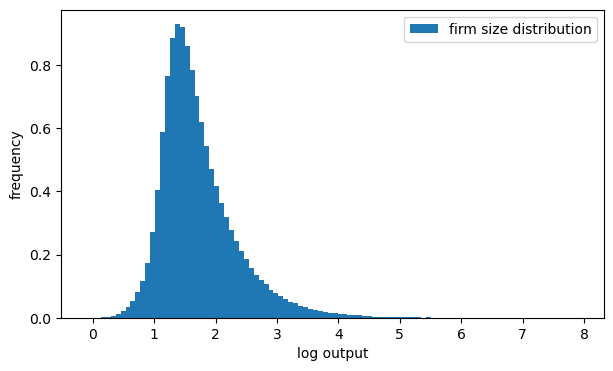

In [29]:
fig, ax = plt.subplots(figsize=(7, 4))
ax.hist(np.log(output_dist), bins=100, density=True,
        label="firm size distribution")
ax.set_xlabel("log output")
ax.set_ylabel("frequency")
ax.legend()
plt.show()

## Pareto tails

The firm size distribution shown above appears to have a long right tail.

This matches the observed firm size distribution.

In fact the firm size distribution obeys a **power law**.

More mathematically, the distribution of firm size has a Pareto right hand tail, so that there exist constants $k, \alpha > 0$ with

$$
   \mu((x, \infty)) \approx kx^{-\alpha} \text{ when $x$ is large}
$$

Here $\alpha$ is called the tail index.

Does the model replicate this feature?

One option is to look at the empirical counter CDF (cumulative distribution).

The idea is as follows: The counter CDF of a random variable $X$ is 

$$
   G(x) := \mathbb P\{X > x\}
$$

In the case of a Pareto tailed distribution we have $\mathbb P\{X > x\} \approx k x^{-\alpha}$ for large $x$.

Hence, for large $x$,

$$
    \ln G(x) \approx \ln k - \alpha \ln x
$$

The empirical counterpart of $G$ given sample $X_1, \ldots, X_n$ is 

$$
    G_n (x) := \frac{1}{n} \sum_{i=1}^n \mathbf 1 \{X_i > x \}
$$

For large $k$ (implying $G_n \approx G$) and large $x$, we expect that, for a Pareto-tailed sample, $\ln G_n$ is approximately linear.

Here's a function to compute the empirical counter CDF:

In [30]:
def ECCDF(data):
    """
    Return a function that implements the ECCDF given the data.
    """
    def eccdf(x):
        return np.mean(data > x)
    return eccdf

Let's plot the empirical counter CDF of the output distribution.

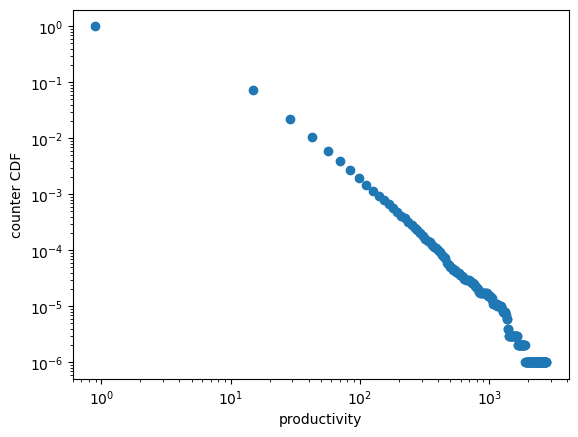

In [31]:
eccdf = ECCDF(output_dist)

ϵ = 10e-10
x_grid = np.linspace(output_dist.min()+ϵ, output_dist.max()-ϵ, 200)
y = [eccdf(x) for x in x_grid]

fix, ax = plt.subplots()
ax.loglog(x_grid, y, 'o', label="ECCDF")
ax.set_xlabel("productivity")
ax.set_ylabel("counter CDF")
plt.show()

**Exercise**

Plot the same output distribution, but this time using a rank-size plot.

If the rank-size plot is approximately linear, the data suggests a Pareto tail.

You can use QuantEcon's `rank_size` function --- here's an example of usage.

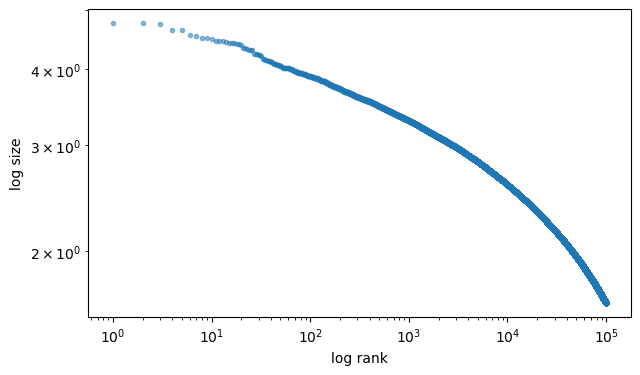

In [32]:
x = np.abs(np.random.randn(1_000_000))
rank_data, size_data = qe.rank_size(x, c=0.1)
fig, ax = plt.subplots(figsize=(7,4))
ax.loglog(rank_data, size_data, "o", markersize=3.0, alpha=0.5)
ax.set_xlabel("log rank")
ax.set_ylabel("log size")
plt.show()

This plot is not linear --- as expected, since we are using a folded normal distribution.

In [33]:
for i in range(12):
    print("solution below.")

solution below.
solution below.
solution below.
solution below.
solution below.
solution below.
solution below.
solution below.
solution below.
solution below.
solution below.
solution below.


**Solution**

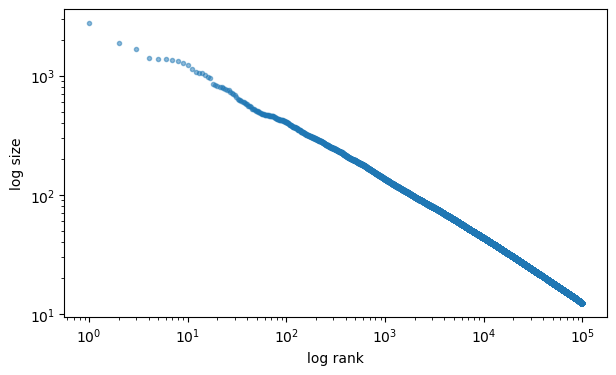

In [34]:
rank_data, size_data = qe.rank_size(output_dist, c=0.1)
fig, ax = plt.subplots(figsize=(7,4))
ax.loglog(rank_data, size_data, "o", markersize=3.0, alpha=0.5)
ax.set_xlabel("log rank")
ax.set_ylabel("log size")
plt.show()

This looks very linear --- the model generates Pareto tails.

(In fact it's possible to prove this.)

**Exercise**

As an exercise, let's look at the fixed cost paid by incumbents each period and how it relates to the equilibrium price.

We expect that a higher fixed cost will reduce supply and hence increase the market price.

For the fixed costs, use

In [35]:
c_values = np.linspace(2.5, 5.0, 10)

In [36]:
for i in range(12):
    print("solution below.")

solution below.
solution below.
solution below.
solution below.
solution below.
solution below.
solution below.
solution below.
solution below.
solution below.
solution below.
solution below.


**Solution**

Equilibrium price when c = 2.5 is 1.1
Equilibrium price when c = 2.8 is 1.2
Equilibrium price when c = 3.1 is 1.3
Equilibrium price when c = 3.3 is 1.3
Equilibrium price when c = 3.6 is 1.4
Equilibrium price when c = 3.9 is 1.5
Equilibrium price when c = 4.2 is 1.5
Equilibrium price when c = 4.4 is 1.6
Equilibrium price when c = 4.7 is 1.7
Equilibrium price when c = 5.0 is 1.7


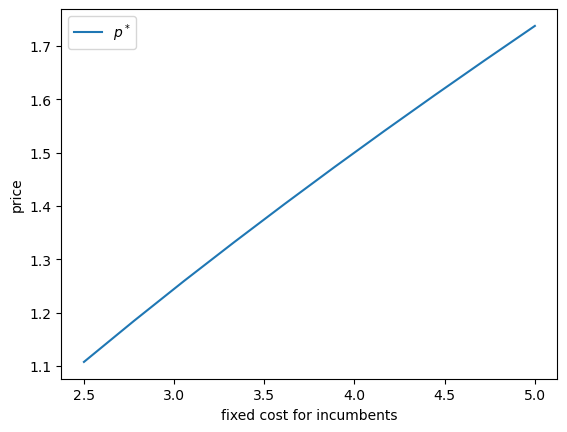

In [37]:
eq_prices = np.empty_like(c_values)
for i, c in enumerate(c_values):
    model = create_model(c=c)
    p_star, v_bar, φ_star, φ_sample, s, m_star = \
        compute_equilibrium_prices_and_quantities(model)
    eq_prices[i] = p_star
    print(f"Equilibrium price when c = {c:.2} is {p_star:.2}")

fig, ax = plt.subplots()
ax.plot(c_values, eq_prices, label="$p^*$")
ax.set_xlabel("fixed cost for incumbents")
ax.set_ylabel("price")
ax.legend()
plt.show()